In [1]:
# !pip install catboost
# !pip3 install imblearn

In [12]:
import pandas as pd
import numpy as np
from collections import Counter
import itertools

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler                          
from sklearn.metrics import roc_auc_score, f1_score, silhouette_score, homogeneity_score,\
completeness_score, v_measure_score, confusion_matrix, classification_report, accuracy_score,\
recall_score, precision_score, average_precision_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_rows', 1000) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

from catboost import CatBoostClassifier, Pool, cv
from xgboost import XGBClassifier as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from tqdm import tqdm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns

In [6]:
RANDOM_STATE =42
np.random.seed(RANDOM_STATE)
labels=["Норма","Прихват"]

In [7]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the classifier.
    
    :arg clf: scikit-learn classifier
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)[:, 1]
    
    return X_meta_train, X_meta_test

In [8]:
def generate_metafeatures(classifiers, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of classifiers.
    
    :arg classifiers: list of scikit-learn classifiers
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

In [17]:
metrics = {
    'precision': [],
    'recall': []
}
for i in range(1, 6):
    path = r'C:\Users\shers\Desktop\SF\Буровая\cross_val_pred_30\fold_' + str(i) +\
    '\StuckPipe_train'
        
    %load_ext autoreload
    %autoreload 1
    %aimport reading_data
    reading_data.walk_dir(path)
        
    data = pd.read_csv('data.csv')
#     X =data[[
#         'GR', 'SPPA_APRS', 'ECD', 'APRS', 'RPM', 'FLWI','STOR', 'BPOS', 'SPPA',
#         'DDEPT_3', 'DDEPT_6', 'conner', 'F', 'PDEPT', 'DBPOS_3','DBPOS_6',  'DEPT'
#              ]].values
    X =data[[
#          'F', 'STOR', 'SPPA_APRS', 'FSTOR_3', 'HKLD_bin_new',
#          'DSPPA_3', 'BVEL_bin', 
#          'DSPPA_18', 'DSPPA_6', 'FDEPT_3', 'ANOMAL', 'DBPOS_6', 'DBVEL_6', 'HKLD', 'DBVEL_12', 
#          'DHKLD_12', 'DBVEL_18', 'FBPOS_3', 'DRPM', 'RPM', 'SPPA_APRS_back1', 'ESD', 'FSPPA_3', 
#          'DSTOR_18', 'DSPPA_12', 'BPOS', 'FLWI', 'DBPOS_18', 'FHKLD_3', 'DSPPA_APRS_3', 'DBVEL_3', 
#          'DDEPT_18', 'DRPM_18', 'ECD', 'PDEPT', 'DSTOR_12', 'FSPPA_APRS_3', 'SPPA', 'DHKLD_18',
#          'DHKLD_6', 'DSPPA', 'DEPT', 'F_all', 'DBPOS_12'
        'DEPT', 'HDTH', 'BPOS', 'HKLD', 'STOR', 'FLWI', 'RPM',
        'SPPA', 'ECD', 'DLS', 'INCL', 'AZIM', 'GR', 'APRS', 'BVEL', 'RIG_STATE',
        'ESD', 'Stick', 'DDEPT_1', 'DDEPT_3', 'DDEPT',
        'DDEPT_6', 'DDEPT_12', 'DDEPT_18', 'DBPOS', 'DBPOS_1', 'DBPOS_3',
        'DBPOS_6', 'DBPOS_12', 'DBPOS_18', 'DHKLD', 'DHKLD_1', 'DHKLD_3', 'DHKLD_6', 
        'DHKLD_12', 'DHKLD_18', 'DSPPA', 'DSPPA_1',
        'DSPPA_3', 'DSPPA_6', 'DSPPA_12', 'DSPPA_18',
        'DRPM', 'DRPM_1', 'DRPM_3', 'DRPM_6', 'DRPM_12', 'DRPM_18', 
        'DBVEL', 'DBVEL_1', 'DBVEL_3', 'DBVEL_6', 'FBVEL_1', 'DBVEL_12', 'DBVEL_18',
        'DSTOR_1', 'DSTOR_3', 'DSTOR_6', 'DSTOR_12', 'DSTOR_18',
        'SPPA_APRS', 'DSPPA_APRS_1', 'DSPPA_APRS_3', 'DSPPA_APRS_6',
        'DSPPA_APRS_12', 'DSPPA_APRS_18', 'DECD', 'ANOMAL',
        'discardSPPA', 'discardSTOR', 'discardECD', 'discardStick', 'discardAPRS', 'discardRPM',
        'PDEPT', 'F', 'F_all', 'conner', 'conner_delta', 'GR_type',
        'DEPT_back3', 'SPPA_back3', 'SPPA_APRS_back3',
        'BVEL_back3', 'HKLD_back3', 'BPOS_back3', 
        'RPM_back3', 'STOR_back3', 'DEPT_back1', 'SPPA_back1', 'SPPA_APRS_back1',
        'BVEL_back1', 'HKLD_back1', 'BPOS_back1', 
        'RPM_back1', 'STOR_back1'
    ]].values 
    
#     # нормализация:
#     sc = StandardScaler()    # MaxAbsScaler- StandardScaler+ RobustScaler+
#     X = sc.fit_transform(X)
    y = data['StuckPipe'].values
    
    X_train = X[0:23000]
    X_val = X[23000:]
    y_train = y[0:23000]
    y_val = y[23000:]
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, shuffle=False, random_state=RANDOM_STATE)
    
#     X, y = SMOTE(random_state=RANDOM_STATE).fit_resample(X, y)
#     classes = np.unique(y_train)
#     weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
#     class_weights = dict(zip(classes, weights))
#     model = XGBClassifier(learning_rate=0.01, 
#                            penalty='l1',
#                            class_weight= {0:1, 1:5},
#                            n_estimators=1000, max_depth=9)
#     model = CatBoostClassifier(iterations=4000,
#                         depth=9,
#                         learning_rate=0.001,
#                         #custom_loss=['Accuracy'],
#                         loss_function='Logloss', 
#                         class_weights={0:1, 1:5},
# #                         class_weights=class_weights,
# #                         auto_class_weights='Balanced',
#                         eval_metric='Accuracy',
# #                         l2_leaf_reg=1,
#                         verbose=True, 
#                         use_best_model=True,
#                         task_type='CPU')
    cv = KFold(n_splits=10, shuffle=True)

    stacked_features_train, stacked_features_test = generate_metafeatures([
        LogisticRegression(C=0.001, penalty='l1', solver='liblinear', max_iter=5000),
        LogisticRegression(C=0.001, penalty='l2', solver='liblinear', max_iter=5000),  
        RandomForestClassifier(n_estimators=300, n_jobs=-1),
        GradientBoostingClassifier(n_estimators=300)
    ], X_train, X_val, y_train, cv)
    
    total_features_train = np.hstack([X_train, stacked_features_train])
    total_features_test = np.hstack([X_val, stacked_features_test])
    
    model = LogisticRegression(penalty='none', solver='lbfgs')
#     model.fit(X, y)
#     model.fit(X_train, y_train, eval_set = (X_val, y_val), 
#           early_stopping_rounds=500)
    model.fit(total_features_train, y_train)
    
    path = r'C:\Users\shers\Desktop\SF\Буровая\cross_val_pred_30\fold_' + str(i) +\
    '\StuckPipe_test'
    
    %load_ext autoreload
    %autoreload 1
    %aimport reading_data
    reading_data.walk_dir(path)
    
    data = pd.read_csv('data.csv')
    
#     X =data[[
#         'GR', 'SPPA_APRS', 'ECD', 'APRS', 'RPM', 'FLWI','STOR', 'BPOS', 'SPPA',
#         'DDEPT_3', 'DDEPT_6', 'conner', 'F', 'PDEPT', 'DBPOS_3','DBPOS_6',  'DEPT'
#              ]].values 
    X =data[[
#          'F', 'STOR', 'SPPA_APRS', 'FSTOR_3', 'HKLD_bin_new',
#          'DSPPA_3', 'BVEL_bin', 
#          'DSPPA_18', 'DSPPA_6', 'FDEPT_3', 'ANOMAL', 'DBPOS_6', 'DBVEL_6', 'HKLD', 'DBVEL_12', 
#          'DHKLD_12', 'DBVEL_18', 'FBPOS_3', 'DRPM', 'RPM', 'SPPA_APRS_back1', 'ESD', 'FSPPA_3', 
#          'DSTOR_18', 'DSPPA_12', 'BPOS', 'FLWI', 'DBPOS_18', 'FHKLD_3', 'DSPPA_APRS_3', 'DBVEL_3', 
#          'DDEPT_18', 'DRPM_18', 'ECD', 'PDEPT', 'DSTOR_12', 'FSPPA_APRS_3', 'SPPA', 'DHKLD_18',
#          'DHKLD_6', 'DSPPA', 'DEPT', 'F_all', 'DBPOS_12'
        'DEPT', 'HDTH', 'BPOS', 'HKLD', 'STOR', 'FLWI', 'RPM',
        'SPPA', 'ECD', 'DLS', 'INCL', 'AZIM', 'GR', 'APRS', 'BVEL', 'RIG_STATE',
        'ESD', 'Stick', 'DDEPT_1', 'DDEPT_3', 'DDEPT',
        'DDEPT_6', 'DDEPT_12', 'DDEPT_18', 'DBPOS', 'DBPOS_1', 'DBPOS_3',
        'DBPOS_6', 'DBPOS_12', 'DBPOS_18', 'DHKLD', 'DHKLD_1', 'DHKLD_3', 'DHKLD_6', 
        'DHKLD_12', 'DHKLD_18', 'DSPPA', 'DSPPA_1',
        'DSPPA_3', 'DSPPA_6', 'DSPPA_12', 'DSPPA_18',
        'DRPM', 'DRPM_1', 'DRPM_3', 'DRPM_6', 'DRPM_12', 'DRPM_18', 
        'DBVEL', 'DBVEL_1', 'DBVEL_3', 'DBVEL_6', 'FBVEL_1', 'DBVEL_12', 'DBVEL_18',
        'DSTOR_1', 'DSTOR_3', 'DSTOR_6', 'DSTOR_12', 'DSTOR_18',
        'SPPA_APRS', 'DSPPA_APRS_1', 'DSPPA_APRS_3', 'DSPPA_APRS_6',
        'DSPPA_APRS_12', 'DSPPA_APRS_18', 'DECD', 'ANOMAL',
        'discardSPPA', 'discardSTOR', 'discardECD', 'discardStick', 'discardAPRS', 'discardRPM',
        'PDEPT', 'F', 'F_all', 'conner', 'conner_delta', 'GR_type',
        'DEPT_back3', 'SPPA_back3', 'SPPA_APRS_back3',
        'BVEL_back3', 'HKLD_back3', 'BPOS_back3', 
        'RPM_back3', 'STOR_back3', 'DEPT_back1', 'SPPA_back1', 'SPPA_APRS_back1',
        'BVEL_back1', 'HKLD_back1', 'BPOS_back1', 
        'RPM_back1', 'STOR_back1'
    ]].values 
    
#     X = sc.fit_transform(X)
    y_pred = data['StuckPipe'].values

    stacked_features_train, stacked_features_test = generate_metafeatures([
        LogisticRegression(C=0.001, penalty='l1', solver='liblinear', max_iter=5000),
        LogisticRegression(C=0.001, penalty='l2', solver='liblinear', max_iter=5000),  
        RandomForestClassifier(n_estimators=300, n_jobs=-1),
        GradientBoostingClassifier(n_estimators=300)
    ], X, X, y_pred, cv)
    
    total_features_train = np.hstack([X, stacked_features_train])
    total_features_test = np.hstack([X, stacked_features_test])
    
    predict_cat = model.predict_proba(total_features_test)
    df=pd.DataFrame()
    df = pd.DataFrame((_ for _ in itertools.zip_longest(*predict_cat))).T
    df.rename(columns = {0:'predict', 1:'Predict'}, inplace = True)
    df['mark'] = 0
    df.loc[df['Predict'] > 0.5, 'mark'] = 1
    predict_list = df['mark'].tolist()
    
#     for i in range(len(predict_list)-4):
#         if predict_list[i]==0 and predict_list[i-1]==1 and predict_list[i+1]==1:
#             predict_list[i]=1
#         if predict_list[i]==0 and predict_list[i-1]==1 and predict_list[i+2]==1:
#             predict_list[i]=1
    
#         if predict_list[i]==1 and predict_list[i-1]==0 and predict_list[i+1]==0:
#             predict_list[i]=0
#         if predict_list[i]==1 and predict_list[i-1]==0 and predict_list[i+2]==0:
#             predict_list[i]=0
#         if predict_list[i]==1 and predict_list[i-1]==0 and predict_list[i+3]==0:
#             predict_list[i]=0
#     if predict_list[i]==1 and predict_list[i-1]==0 and predict_list[i+4]==0:
#         predict_list[i]=0
      
    
    rec = recall_score(y_pred, predict_list)
    pres = precision_score(y_pred, predict_list)
    
    metrics['precision'].append(pres)
    metrics['recall'].append(rec)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [56:15<00:00, 843.76s/it]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:47<00:00, 56.86s/it]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [1:03:42<00:00, 955.66s/it]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:32<00:00, 53.25s/it]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [1:01:08<00:00, 917.12s/it]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:10<00:00, 47.65s/it]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [1:04:45<00:00, 971.48s/it]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:40<00:00, 70.12s/it]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [1:04:03<00:00, 960.92s/it]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:47<00:00, 56.80s/it]


In [18]:
print(metrics)

{'precision': [0.056074766355140186, 0.07339449541284404, 0.2857142857142857, 0.5, 0.5], 'recall': [0.04316546762589928, 0.05925925925925926, 0.014184397163120567, 0.03597122302158273, 0.00641025641025641]}


In [19]:
df = pd.DataFrame(metrics)
display(df)

,precision,recall
0,0.056075,0.043165
1,0.073394,0.059259
2,0.285714,0.014184
3,0.500000,0.035971
4,0.500000,0.006410


In [7]:
print(df.precision.mean(), df.recall.mean())

0.5427288220813614 0.5819876646418817


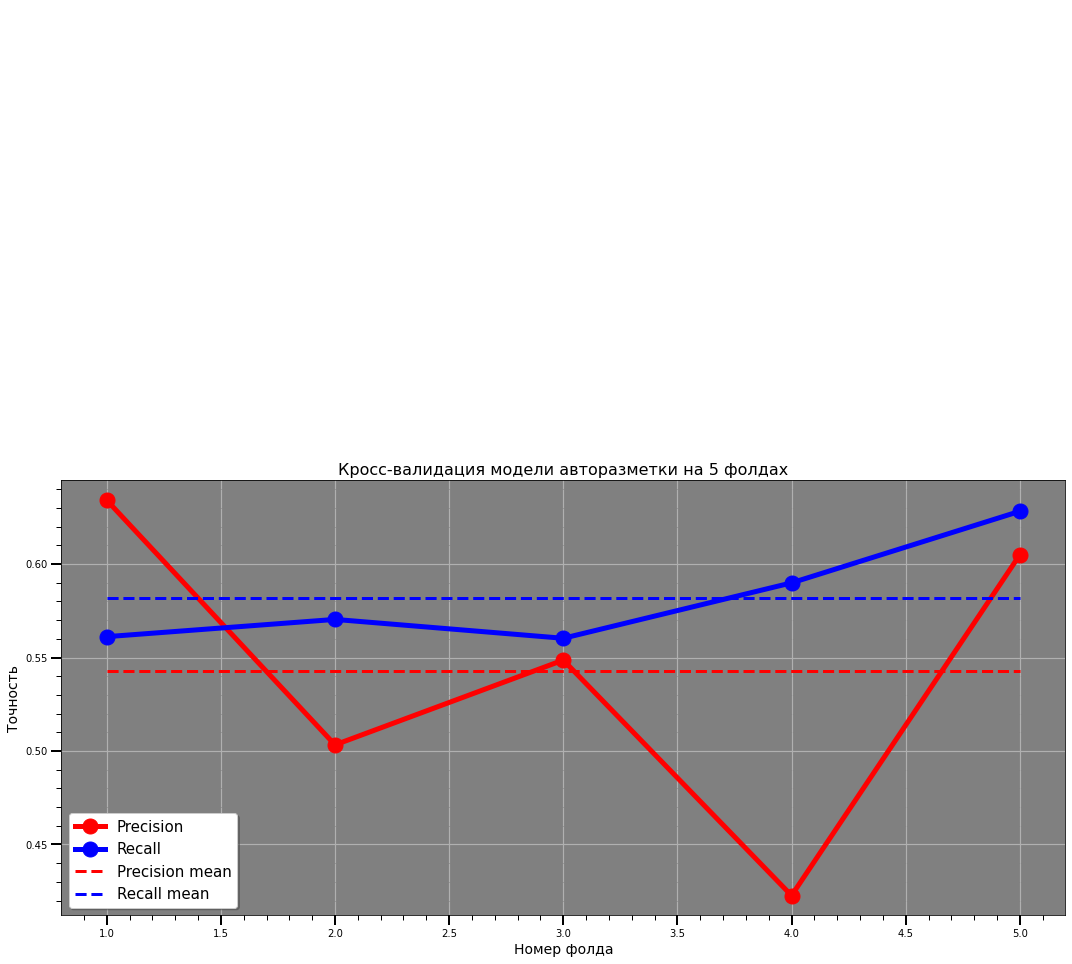

In [8]:
# plt.plot(df.index, df.precision, df.index, df.recall)
# plt.title("Кросс-валидация модели авторазметки на 10 фолдах", fontsize=16) # заголовок
# plt.xlabel("Номер фолда", fontsize=16) # ось абсцисс
# plt.ylabel("Точность", fontsize=14)
# plt.grid(which="major", linewidth=1.2)
# plt.grid(which="minor", linestyle="--", color="gray", linewidth=0.5)
df['precision_mean'] = df.precision.mean()
df['recall_mean'] = df.recall.mean()

fig, ax = plt.subplots(figsize=(18, 8))

fig.set(facecolor = 'w')
ax.set(facecolor = 'grey')

ax.set_title("Кросс-валидация модели авторазметки на 5 фолдах", fontsize=16)
ax.set_xlabel("Номер фолда", fontsize=14)        
ax.set_ylabel("Точность", fontsize=14)

ax.grid(which="major", linewidth=1.2)
ax.grid(which="minor", linestyle="--", color="gray", linewidth=0.5)
ax.plot(df.index+1, df.precision, color="red", label="Precision", linewidth = 5, marker = 'o', markersize=15)
ax.plot(df.index+1, df.recall, color ='blue', label="Recall", linewidth = 5, marker = 'o', markersize=15)
ax.plot(df.index+1, df.precision_mean, color="red", label="Precision mean", linewidth = 3, linestyle = '--')
ax.annotate(round(df.recall.mean(), 2), xy=(5, 0.89), fontsize = 20)
ax.plot(df.index+1, df.recall_mean, color='blue', label="Recall mean", linewidth = 3, linestyle = '--')
ax.annotate(round(df.precision.mean(), 2), xy=(5, 0.78), fontsize = 20)
ax.legend(shadow = True, fontsize = 15)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='major', length=10, width=2)
ax.tick_params(which='minor', length=5, width=1)

plt.show()